# params

In [1]:
dbg = False
if dbg:
    dbgsz = 500


p_o = '.'
SEED = 111

BS = 128
SZ = 224
FP16 = False


# setup

In [2]:
import fastai
print('fastai.__version__: ', fastai.__version__)

import random 
import numpy as np
import torch
import os

def set_torch_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        torch.backends.cudnn.deterministic = True 
        torch.backends.cudnn.benchmark = False

set_torch_seed()

from fastai import *
from fastai.vision import *

import scipy as sp
from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y1, y2):
    return cohen_kappa_score(y1, y2, weights='quadratic')

fastai.__version__:  1.0.54


# preprocess

In [3]:
img2grd = []

p = '../input/aptos2019-blindness-detection'
pp = Path(p)
train = pd.read_csv(pp/'train.csv')
test  = pd.read_csv(pp/'test.csv')
len_blnd = len(train)
len_blnd_test = len(test)

img2grd_blnd = [(f'{p}/train_images/{o[0]}.png',o[1])  for o in train.values]

len_blnd, len_blnd_test

(3662, 1928)

In [4]:
img2grd += img2grd_blnd
display(len(img2grd))
display(Counter(o[1] for o in img2grd).most_common())

3662

[(0, 1805), (2, 999), (1, 370), (4, 295), (3, 193)]

In [5]:
if not np.all([Path(o[0]).exists() for o in img2grd]): print('Some files are missing!!!')

In [6]:
df = pd.DataFrame(img2grd)
df.columns = ['fnm', 'target']

df.shape

(3662, 2)

In [7]:
set_torch_seed()
idx_blnd_train = np.where(df.fnm.str.contains('aptos2019-blindness-detection/train_images'))[0]
idx_val = np.random.choice(idx_blnd_train, int(len_blnd*0.10), replace=False)
df['is_val']=False
df.loc[idx_val, 'is_val']=True

if dbg:
    df=df.head(dbgsz)

# dataset

In [8]:
%%time
tfms = get_transforms()

def get_data(sz, bs):
    src = (ImageList.from_df(df=df,path='./',cols='fnm') 
            .split_from_df(col='is_val') 
            .label_from_df(cols='target',  
                           label_cls=FloatList)
          )

    data= (src.transform(tfms, size=sz) #Data augmentation
            .databunch(bs=bs) #DataBunch
            .normalize(imagenet_stats) #Normalize     
           )
    return data

bs = BS 
sz = SZ
set_torch_seed()
data = get_data(sz, bs)

CPU times: user 21.4 s, sys: 5.12 s, total: 26.6 s
Wall time: 27.1 s


CPU times: user 4.33 s, sys: 1.42 s, total: 5.76 s
Wall time: 1min 11s


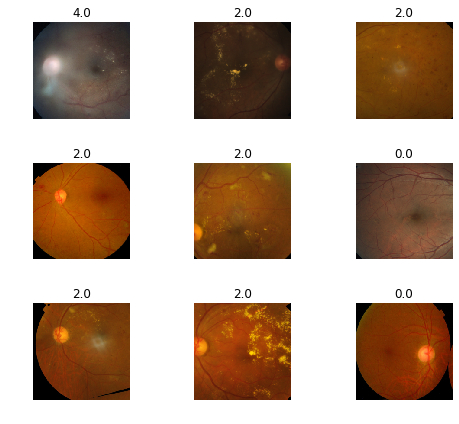

In [9]:
%%time
data.show_batch(rows=3, figsize=(7,6))

# model

In [10]:
%%time
# Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth

# Making pretrained weights work without needing to find the default filename
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
!cp '../input/pytorch-vision-pretrained-models/resnet50-19c8e357.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

CPU times: user 16 ms, sys: 24 ms, total: 40 ms
Wall time: 823 ms


In [11]:
learn = cnn_learner(data, 
                    base_arch = models.resnet50, 
                    path=p_o)
learn.loss = MSELossFlat

if FP16: learn = learn.to_fp16()

In [12]:
learn.freeze()

In [13]:
%%time
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 13 s, sys: 21.1 s, total: 34.1 s
Wall time: 24min 27s


Min numerical gradient: 2.29E-02
Min loss divided by 10: 1.45E-02


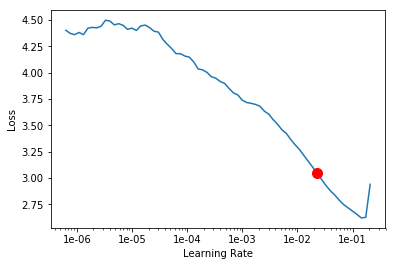

In [14]:
learn.recorder.plot(suggestion=True)

In [15]:
set_torch_seed()
learn.fit_one_cycle(15, max_lr=1e-2)

epoch,train_loss,valid_loss,time
0,2.575467,1.311029,07:51
1,1.787967,0.724872,07:49
2,1.206011,0.578640,07:53
3,0.860023,0.344292,07:51
4,0.660258,0.309126,07:48
5,0.530875,0.375281,07:50
6,0.456596,0.371196,07:51
7,0.404231,0.354579,07:48
8,0.364227,0.284283,07:52
9,0.334380,0.325576,07:49


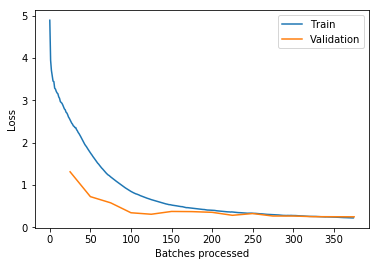

In [16]:
learn.recorder.plot_losses()
# learn.recorder.plot_metrics()

In [17]:
learn.save('mdl-frozen')

In [18]:
!nvidia-smi

Mon Jul  8 15:52:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    38W / 250W |  13373MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [19]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 2.75E-07
CPU times: user 16.2 s, sys: 21.6 s, total: 37.8 s
Wall time: 22min 26s


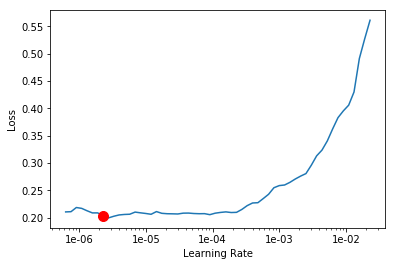

In [20]:
%%time
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [21]:
set_torch_seed()
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,time
0,0.196848,0.250741,08:20
1,0.204304,0.272312,08:21
2,0.212028,0.397628,08:25
3,0.202468,0.258009,08:22
4,0.186764,0.259721,08:19
5,0.167222,0.276921,08:23
6,0.148483,0.273165,08:24
7,0.136034,0.264341,08:20
8,0.124323,0.258437,08:24
9,0.113753,0.258309,08:20


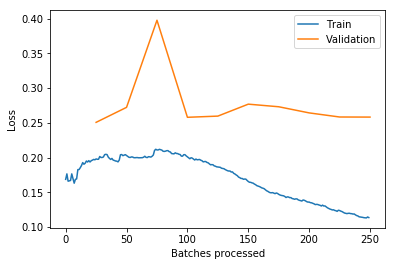

In [22]:
learn.recorder.plot_losses()
# learn.recorder.plot_metrics()

In [23]:
learn.save('mdl')

In [24]:
!nvidia-smi

Mon Jul  8 17:38:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    39W / 250W |  13425MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# validate and thresholding

In [25]:
learn = learn.to_fp32()

In [26]:
%%time
set_torch_seed()
preds_val, y_val = learn.get_preds(ds_type=DatasetType.Valid)

CPU times: user 268 ms, sys: 596 ms, total: 864 ms
Wall time: 55.2 s


In [27]:
preds_val = preds_val.numpy().squeeze()
y_val= y_val.numpy()

In [28]:
np.save(f'{p_o}/preds_val.npy', preds_val)
np.save(f'{p_o}/y_val.npy', y_val)

In [29]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/88773#latest-515044
# We used OptimizedRounder given by hocop1. https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
# put numerical value to one of bins
def to_bins(x, borders):
    for i in range(len(borders)):
        if x <= borders[i]:
            return i
    return len(borders)

class Hocop1OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _loss(self, coef, X, y, idx):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        ll = -quadratic_weighted_kappa(y, X_p)
        return ll

    def fit(self, X, y):
        coef = [1.5, 2.0, 2.5, 3.0]
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(1, 2), (1.5, 2.5), (2, 3), (2.5, 3.5)]
        for it1 in range(10):
            for idx in range(4):
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                coef[idx] = a
                la = self._loss(coef, X, y, idx)
                coef[idx] = b
                lb = self._loss(coef, X, y, idx)
                for it in range(20):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        coef[idx] = a
                        la = self._loss(coef, X, y, idx)
                    else:
                        b = b - (b - a) * golden2
                        coef[idx] = b
                        lb = self._loss(coef, X, y, idx)
        self.coef_ = {'x': coef}

    def predict(self, X, coef):
        X_p = np.array([to_bins(pred, coef) for pred in X])
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [30]:
# https://www.kaggle.com/c/petfinder-adoption-prediction/discussion/76107#480970
class AbhishekOptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [31]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [32]:
optnm2coefs = {'simple': [0.5, 1.5, 2.5, 3.5]}

In [33]:
%%time
set_torch_seed()
optR = Hocop1OptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['hocop1'] = optR.coefficients()

CPU times: user 2.36 s, sys: 0 ns, total: 2.36 s
Wall time: 2.36 s


In [34]:
%%time
set_torch_seed()
optR = AbhishekOptimizedRounder()
optR.fit(preds_val, y_val)
optnm2coefs['abhishek'] = optR.coefficients()

CPU times: user 288 ms, sys: 0 ns, total: 288 ms
Wall time: 286 ms


In [35]:
optnm2coefs

{'simple': [0.5, 1.5, 2.5, 3.5],
 'hocop1': [1.0000660342883434,
  1.5000660342883434,
  2.5836374372491853,
  3.0623853623414865],
 'abhishek': array([0.425982, 1.419254, 2.770101, 3.849405])}

In [36]:
optnm2preds_val_grd = {k: bucket(preds_val, coef) for k,coef in optnm2coefs.items()}
optnm2qwk = {k: quadratic_weighted_kappa(y_val, preds) for k,preds in optnm2preds_val_grd.items()}

In [37]:
optnm2qwk

{'simple': 0.9029597689119605,
 'hocop1': 0.9029731055233753,
 'abhishek': 0.9163176252535719}

In [38]:
Counter(y_val).most_common()

[(0.0, 173), (2.0, 110), (1.0, 31), (4.0, 28), (3.0, 24)]

In [39]:
preds_val_grd = optnm2preds_val_grd['simple'].squeeze()

In [40]:
preds_val_grd.mean()

1.139344262295082

In [41]:
Counter(preds_val_grd).most_common()

[(0.0, 177), (2.0, 106), (3.0, 43), (1.0, 28), (4.0, 12)]

In [42]:
list(zip(preds_val_grd, y_val))[:10]

[(0.0, 1.0),
 (2.0, 2.0),
 (2.0, 2.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (3.0, 4.0),
 (0.0, 0.0),
 (3.0, 4.0)]

In [43]:
(preds_val_grd== y_val.squeeze()).mean()

0.8005464480874317

In [44]:
pickle.dump(optnm2qwk, open(f'{p_o}/optnm2qwk.p', 'wb'))
pickle.dump(optnm2preds_val_grd, open(f'{p_o}/optnm2preds_val_grd.p', 'wb'))
pickle.dump(optnm2coefs, open(f'{p_o}/optnm2coefs.p', 'wb'))

# testing

In [45]:
df_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [46]:
learn.data.add_test(
    ImageList.from_df(df_test,
                      '../input/aptos2019-blindness-detection',
                      folder='test_images',
                      suffix='.png'))

In [47]:
%%time
set_torch_seed()
preds_tst, _ = learn.get_preds(ds_type=DatasetType.Test)
preds_tst = preds_tst.numpy().squeeze()

CPU times: user 1.21 s, sys: 1.94 s, total: 3.16 s
Wall time: 1min 40s


In [48]:
np.save(f'{p_o}/preds_tst.npy', preds_tst)

In [49]:
def bucket(preds_raw, coef = [0.5, 1.5, 2.5, 3.5]):
    preds = np.zeros(preds_raw.shape)
    for i, pred in enumerate(preds_raw):
        if pred < coef[0]:
            preds[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            preds[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            preds[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            preds[i] = 3
        else:
            preds[i] = 4
    return preds

In [50]:
coef = optnm2coefs['simple']
preds_tst_grd = bucket(preds_tst, coef)

In [51]:
preds_tst_grd.squeeze()

array([1., 2., 3., 2., ..., 2., 3., 3., 1.])

In [52]:
Counter(preds_tst_grd.squeeze()).most_common()

[(2.0, 926), (1.0, 467), (0.0, 290), (3.0, 213), (4.0, 32)]

## submit

In [53]:
subm = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
subm['diagnosis'] = preds_tst_grd.squeeze().astype(int)
subm.head()

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,2
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,2


In [54]:
subm.diagnosis.value_counts()

2    926
1    467
0    290
3    213
4     32
Name: diagnosis, dtype: int64

In [55]:
subm.to_csv(f"{p_o}/submission.csv", index=False)